# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
#!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [15]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [17]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

C:\Users\Usman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.36       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.81      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [19]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

C:\Users\Usman\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-Quote', 'I-Relationship', 'I-Award', 'B-Award', 'O', 'B-Opinion', 'B-Plot', 'I-Quote', 'B-Origin', 'I-Genre', 'B-Character_Name', 'B-Relationship', 'I-Opinion', 'I-Origin', 'I-Plot', 'B-Year', 'B-Actor', 'I-Director', 'I-Year', 'I-Soundtrack', 'B-Genre', 'I-Character_Name', 'B-Director', 'B-Soundtrack', 'I-Actor'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


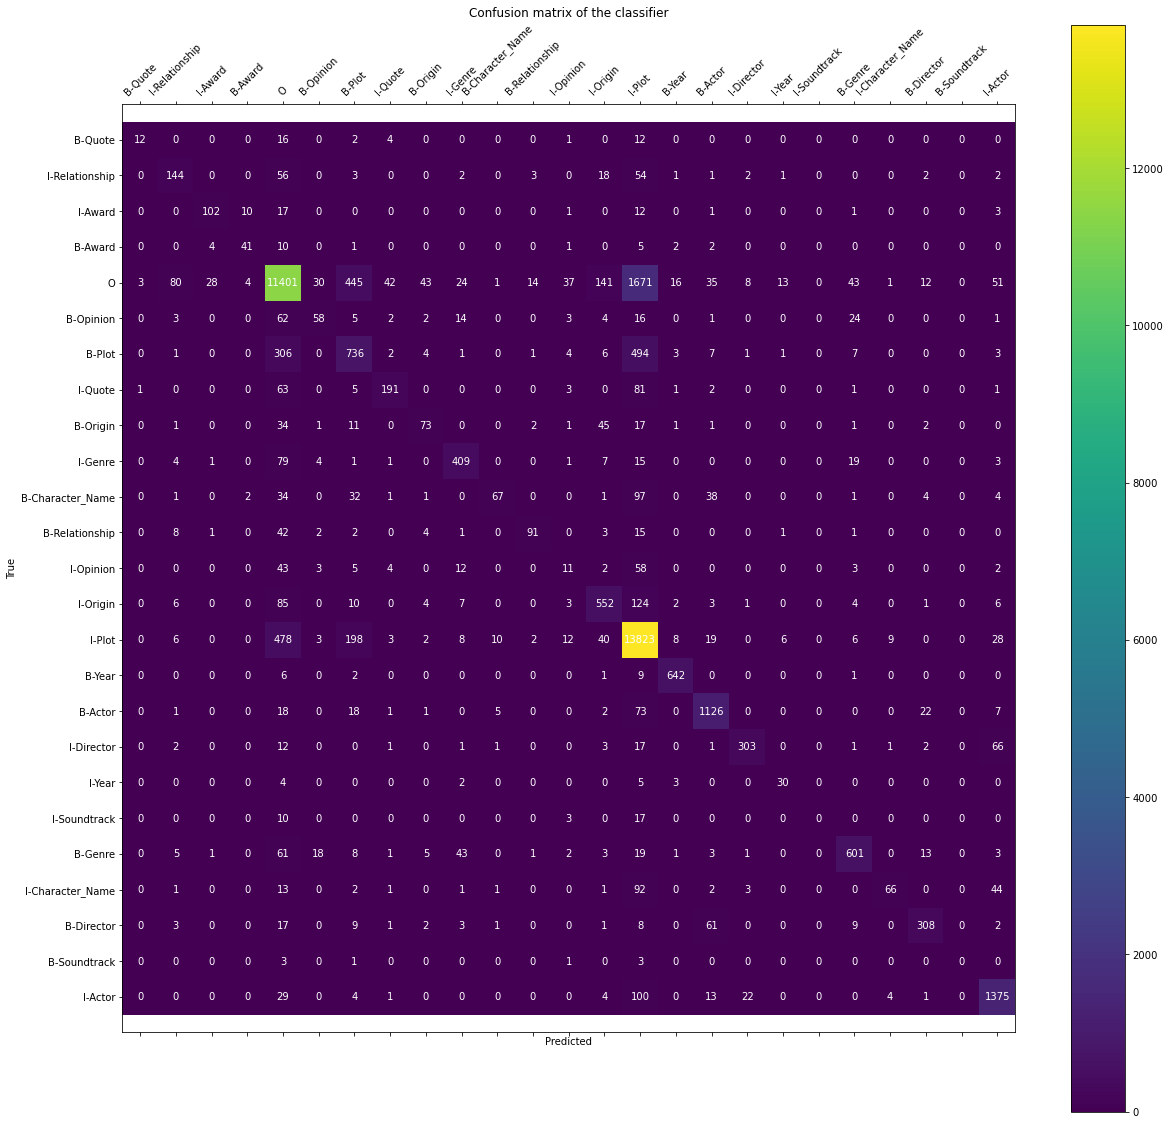

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [22]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [23]:
print_transition_weights(ct._tagger.info().transitions.items())

8.731889 B-Actor  -> I-Actor
8.346452 B-Plot   -> I-Plot
8.063256 B-Director -> I-Director
7.853769 B-Origin -> I-Origin
7.729229 I-Plot   -> I-Plot
7.560399 I-Quote  -> I-Quote
7.407722 B-Character_Name -> I-Character_Name
7.347477 I-Origin -> I-Origin
7.267754 B-Relationship -> I-Relationship
7.142467 B-Quote  -> I-Quote
7.018631 I-Relationship -> I-Relationship
6.874474 I-Soundtrack -> I-Soundtrack
6.791274 I-Opinion -> I-Opinion
6.738424 B-Genre  -> I-Genre
6.696196 B-Soundtrack -> I-Soundtrack
6.590974 B-Award  -> I-Award
6.446605 B-Opinion -> I-Opinion
6.427469 I-Award  -> I-Award
6.361042 I-Genre  -> I-Genre
6.348052 I-Actor  -> I-Actor
6.227569 I-Character_Name -> I-Character_Name
5.431289 I-Director -> I-Director
4.813095 I-Year   -> I-Year
4.075799 B-Year   -> I-Year
3.774895 B-Character_Name -> B-Plot
3.561169 O        -> O
3.559177 I-Character_Name -> B-Plot
3.271588 O        -> B-Plot
3.204448 B-Plot   -> B-Character_Name
3.084227 B-Opinion -> B-Genre
3.018820 O        -> 

In [24]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [25]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.196527 B-Year   HAS_NUM
4.377805 B-Genre  WORD_animated
4.377179 I-Year   WORD_s
3.280417 B-Genre  WORD_thriller
3.007786 B-Quote  WORD_i
2.976568 I-Genre  WORD_animated
2.973407 B-Genre  WORD_action
2.909859 B-Plot   WORD_a
2.905342 B-Opinion WORD_blockbuster
2.686105 B-Award  WORD_oscar
2.666665 B-Genre  WORD_animation
2.598902 B-Relationship SUF_uel
2.574206 B-Director WORD_disney
2.557347 B-Opinion WORD_masterpiece
2.551999 I-Genre  WORD_fiction
2.546444 B-Award  SUF_car
2.518849 B-Relationship WORD_remake
2.460342 B-Actor  WORD_cher
2.438131 B-Genre  WORD_horror
2.420829 I-Genre  WORD_white
2.411938 B-Relationship WORD_sequel
2.407609 I-Genre  WORD_thriller
2.371395 B-Genre  WORD_slasher
2.367687 B-Genre  WORD_comedy
2.336496 B-Origin WORD_adapted
2.302117 I-Actor  WORD_cage
2.276304 B-Genre  WORD_documentary
2.225584 B-Director SUF_xar
2.225584 B-Director WORD_pixar
2.224878 B-Genre  WORD_romance
2.186996 B-Genre  WORD_war
2.181365 B-Award  WORD_won
2.174204 B-Plot   WORD_an
2.

0.688878 I-Actor  WORD_adams
0.688875 I-Director SUF_eau
0.688554 I-Quote  SUF_rld
0.688430 I-Plot   WORD_for
0.688071 B-Plot   WORD_chases
0.687999 I-Actor  WORD_cube
0.687888 B-Origin WORD_frank
0.687776 I-Actor  SUF_rog
0.687776 I-Actor  WORD_frog
0.687346 B-Director WORD_elia
0.687224 I-Character_Name SUF_hor
0.687107 B-Actor  SUF_tty
0.687099 I-Director WORD_boyle
0.686975 I-Director WORD_rodriguez
0.686720 B-Character_Name SUF_mus
0.686718 I-Director WORD_b
0.686514 I-Quote  WORD_clue
0.686296 B-Plot   WORD_who
0.686127 B-Actor  SUF_as
0.685431 I-Actor  WORD_meester
0.685245 I-Actor  WORD_reynolds
0.684904 I-Plot   SUF_zi
0.684606 I-Plot   WORD_other
0.684549 I-Relationship WORD_knocked
0.684491 I-Director WORD_walker
0.684456 B-Year   SUF_000
0.684452 I-Genre  SUF_ong
0.684277 I-Character_Name WORD_pevensie
0.684199 I-Origin WORD_past
0.684136 B-Opinion SUF_ded
0.684109 B-Origin WORD_edgar
0.683953 B-Character_Name SUF_ot
0.683866 I-Plot   WORD_animals
0.683850 I-Relationship WO

0.478065 B-Character_Name WORD_sawyer
0.477915 I-Plot   SUF_oet
0.477915 I-Plot   WORD_poet
0.477897 B-Plot   SUF_low
0.477879 B-Plot   WORD_traveling
0.477824 I-Plot   SUF_dus
0.477781 I-Actor  WORD_bronson
0.477677 B-Actor  SUF_iyi
0.477677 B-Actor  WORD_ziyi
0.477665 I-Actor  WORD_heartedly
0.477608 B-Opinion WORD_departure
0.477495 I-Plot   WORD_tragedy
0.477419 B-Year   SUF_96
0.477419 B-Year   SUF_996
0.477419 B-Year   WORD_1996
0.477289 I-Character_Name WORD_caspian
0.477222 I-Actor  SUF_ung
0.477178 B-Plot   WORD_interweaves
0.477156 B-Opinion WORD_inspired
0.477104 B-Plot   WORD_ballet
0.477064 I-Year   SUF_o
0.477055 I-Plot   WORD_wealthy
0.477033 B-Quote  WORD_speaking
0.477029 B-Soundtrack WORD_hakunamatata
0.477022 I-Year   WORD_thirties
0.476976 B-Character_Name SUF_ce
0.476966 B-Actor  SUF_ob
0.476965 B-Quote  WORD_greed
0.476926 B-Plot   WORD_bumbling
0.476891 B-Plot   WORD_details
0.476842 B-Character_Name WORD_heathcliffe
0.476825 I-Plot   SUF_rip
0.476772 I-Plot   SU

0.394095 B-Director SUF_mir
0.394095 B-Director WORD_amir
0.394086 I-Plot   WORD_revised
0.394074 B-Opinion SUF_cs
0.394065 I-Origin SUF_ror
0.394009 I-Opinion WORD_collection
0.393965 I-Quote  SUF_our
0.393960 I-Actor  WORD_shepard
0.393944 I-Actor  SUF_lea
0.393944 I-Actor  WORD_dullea
0.393920 I-Quote  WORD_behind
0.393851 B-Opinion WORD_notoriously
0.393808 I-Character_Name SUF_van
0.393689 I-Character_Name WORD_treadwell
0.393611 B-Opinion WORD_sweet
0.393603 B-Plot   SUF_ppi
0.393600 B-Origin SUF_sel
0.393596 B-Director SUF_mr
0.393596 B-Director SUF_imr
0.393596 B-Director WORD_nimr
0.393573 B-Character_Name SUF_uty
0.393461 I-Plot   SUF_ust
0.393446 I-Character_Name WORD_end
0.393435 I-Actor  SUF_dow
0.393412 I-Character_Name SUF_ey
0.393313 B-Plot   WORD_fiery
0.393301 I-Actor  WORD_majors
0.393286 B-Plot   WORD_opera
0.393258 B-Soundtrack SUF_ro
0.393231 B-Plot   SUF_eek
0.393121 B-Actor  SUF_opi
0.393121 B-Actor  WORD_whoopi
0.393121 B-Director SUF_ele
0.393118 B-Actor  SUF_

0.329624 I-Plot   WORD_plans
0.329604 I-Quote  WORD_small
0.329595 I-Plot   SUF_ik
0.329534 B-Character_Name SUF_tso
0.329534 B-Character_Name WORD_ratso
0.329441 B-Plot   WORD_veteran
0.329386 I-Plot   WORD_streets
0.329380 I-Actor  WORD_thomas
0.329354 I-Director SUF_rie
0.329314 I-Quote  SUF_ye
0.329311 B-Actor  SUF_ugo
0.329311 B-Actor  WORD_hugo
0.329299 I-Year   WORD_and
0.329253 B-Plot   WORD_outer
0.329248 I-Soundtrack SUF_ger
0.329244 B-Plot   WORD_metallurgy
0.329182 I-Soundtrack SUF_sh
0.329135 I-Plot   WORD_creepy
0.329071 I-Character_Name SUF_lum
0.329046 I-Opinion WORD_acceptance
0.329029 I-Plot   SUF_800
0.329029 I-Plot   WORD_1800
0.328879 B-Plot   WORD_meeting
0.328873 B-Actor  SUF_ese
0.328855 B-Director WORD_katsuhiro
0.328554 B-Relationship WORD_7
0.328543 I-Relationship WORD_wardrobe
0.328524 I-Genre  SUF_nt
0.328508 I-Plot   WORD_madcap
0.328496 I-Genre  WORD_b
0.328372 B-Opinion SUF_ies
0.328362 B-Plot   WORD_pill
0.328359 B-Plot   WORD_each
0.328334 I-Actor  SUF

0.264979 B-Character_Name SUF_nn
0.264964 B-Origin WORD_do
0.264891 B-Origin SUF_ost
0.264873 I-Origin WORD_billy
0.264870 B-Director WORD_carl
0.264755 I-Director WORD_terentino
0.264729 I-Plot   SUF_nit
0.264729 I-Plot   WORD_unit
0.264728 B-Year   SUF_47
0.264728 B-Year   SUF_947
0.264728 B-Year   WORD_1947
0.264653 I-Actor  SUF_odd
0.264653 I-Actor  WORD_todd
0.264601 I-Quote  SUF_lts
0.264576 I-Plot   SUF_ete
0.264517 B-Plot   WORD_open
0.264483 I-Plot   SUF_led
0.264476 I-Quote  WORD_conversation
0.264445 B-Quote  SUF_is
0.264425 B-Origin WORD_and
0.264347 B-Character_Name WORD_antonio
0.264297 B-Award  SUF_ven
0.264244 B-Director WORD_rene
0.264150 B-Genre  SUF_avy
0.264079 B-Plot   WORD_utilizing
0.264071 I-Actor  WORD_bening
0.264063 B-Director SUF_eve
0.264012 I-Plot   WORD_suffers
0.263975 I-Plot   WORD_throne
0.263940 I-Origin SUF_led
0.263928 I-Plot   WORD_burned
0.263919 I-Director SUF_mo
0.263914 I-Plot   SUF_ree
0.263869 I-Plot   WORD_survivor
0.263835 B-Year   SUF_38
0

0.210194 I-Plot   WORD_attack
0.210101 I-Origin SUF_ony
0.210096 I-Soundtrack SUF_k
0.210087 I-Plot   WORD_zombie
0.210049 I-Director WORD_donen
0.210023 B-Opinion SUF_ue
0.210007 B-Plot   SUF_upt
0.210006 B-Character_Name SUF_arl
0.210006 I-Plot   WORD_involvement
0.209908 B-Actor  WORD_jonathon
0.209869 I-Plot   WORD_los
0.209821 I-Quote  SUF_est
0.209743 B-Character_Name SUF_let
0.209718 I-Origin SUF_sky
0.209589 B-Actor  SUF_sa
0.209437 I-Origin WORD_people
0.209426 I-Plot   SUF_hal
0.209334 I-Plot   SUF_ers
0.209277 B-Plot   SUF_pt
0.209262 B-Plot   WORD_dirty
0.209247 B-Plot   WORD_scotsman
0.209215 I-Relationship SUF_mic
0.209158 I-Plot   WORD_situation
0.209136 I-Actor  WORD_justice
0.209136 I-Character_Name WORD_swan
0.209131 I-Plot   WORD_broken
0.209087 B-Plot   WORD_grandparents
0.209026 I-Director SUF_mp
0.208990 I-Character_Name SUF_ale
0.208975 I-Actor  WORD_oldman
0.208961 I-Quote  SUF_ole
0.208949 I-Opinion SUF_ost
0.208902 I-Relationship SUF_re
0.208900 I-Origin SUF_l

0.141522 I-Plot   WORD_tech
0.141504 B-Actor  WORD_bam
0.141454 I-Plot   WORD_rebelled
0.141424 I-Plot   WORD_abused
0.141398 I-Actor  WORD_mcguire
0.141342 I-Plot   WORD_companions
0.141314 I-Origin WORD_erich
0.141275 I-Plot   SUF_eif
0.141269 I-Plot   WORD_janitor
0.141267 I-Plot   WORD_responsible
0.141232 I-Plot   SUF_tom
0.141232 I-Plot   WORD_bottom
0.141187 B-Director WORD_bruce
0.141187 I-Plot   WORD_replaced
0.141167 I-Origin SUF_ird
0.141150 I-Plot   SUF_hed
0.141105 I-Plot   SUF_ofy
0.141105 I-Plot   WORD_goofy
0.141103 B-Origin WORD_one
0.141047 I-Genre  SUF_wn
0.140998 I-Plot   SUF_80
0.140998 I-Plot   SUF_980
0.140998 I-Plot   WORD_1980
0.140872 B-Actor  WORD_sam
0.140707 I-Plot   SUF_1
0.140700 I-Origin SUF_gal
0.140690 I-Plot   WORD_piece
0.140678 B-Plot   WORD_actions
0.140649 I-Genre  WORD_cyberpunk
0.140598 I-Character_Name SUF_oks
0.140569 I-Plot   WORD_discharged
0.140551 I-Actor  WORD_margera
0.140536 I-Actor  WORD_gerard
0.140431 I-Actor  SUF_ier
0.140388 B-Plot

0.083176 B-Character_Name WORD_marvel
0.083112 I-Plot   WORD_ego
0.083000 I-Origin SUF_hor
0.082998 I-Plot   WORD_collector
0.082995 I-Plot   SUF_xth
0.082995 I-Plot   WORD_sixth
0.082989 I-Plot   WORD_views
0.082866 I-Plot   WORD_awakened
0.082834 I-Plot   WORD_compassion
0.082785 B-Director SUF_ha
0.082753 I-Plot   WORD_robin
0.082748 I-Plot   WORD_delinquent
0.082668 B-Plot   WORD_common
0.082586 I-Quote  WORD_him
0.082583 I-Plot   WORD_owls
0.082567 I-Plot   WORD_boring
0.082536 I-Plot   SUF_ti
0.082482 I-Plot   WORD_wish
0.082472 I-Actor  WORD_sean
0.082471 I-Plot   SUF_ude
0.082408 I-Character_Name SUF_lm
0.082355 I-Plot   WORD_helper
0.082305 I-Plot   WORD_fascination
0.082288 I-Plot   WORD_sox
0.082281 I-Quote  SUF_ame
0.082281 I-Plot   SUF_ach
0.082173 I-Plot   WORD_drive
0.082140 I-Origin WORD_james
0.082117 I-Plot   WORD_dolittle
0.082048 I-Plot   WORD_box
0.082034 I-Plot   WORD_narratives
0.081983 I-Opinion WORD_with
0.081920 I-Plot   WORD_workings
0.081878 I-Plot   WORD_ca

0.027238 I-Plot   WORD_granter
0.027172 I-Plot   WORD_hat
0.027167 I-Plot   WORD_delivering
0.027166 I-Plot   WORD_manages
0.027126 I-Plot   WORD_suspended
0.027118 I-Plot   WORD_painting
0.027067 I-Actor  WORD_goslin
0.027052 I-Origin SUF_uk
0.027052 I-Origin SUF_iuk
0.027052 I-Origin WORD_palahniuk
0.027027 I-Plot   WORD_altered
0.027015 I-Plot   WORD_maximum
0.027012 I-Plot   WORD_casting
0.026983 I-Plot   WORD_depressing
0.026975 I-Plot   WORD_angles
0.026961 B-Actor  SUF_gh
0.026939 I-Plot   WORD_goons
0.026938 I-Plot   WORD_discontentment
0.026892 I-Plot   SUF_our
0.026869 I-Plot   WORD_childs
0.026808 I-Plot   WORD_lineup
0.026770 I-Actor  SUF_lda
0.026750 I-Plot   WORD_dwarves
0.026746 I-Plot   WORD_respect
0.026739 I-Plot   WORD_differently
0.026717 B-Plot   WORD_americans
0.026687 I-Plot   WORD_explodes
0.026664 I-Plot   WORD_chimp
0.026642 I-Plot   WORD_jewelery
0.026638 I-Actor  WORD_glenn
0.026512 I-Plot   WORD_spread
0.026507 I-Plot   WORD_bankrupt
0.026496 I-Plot   WORD_

0.004427 I-Plot   WORD_egyptian
0.004424 I-Plot   WORD_overdose
0.004409 I-Plot   WORD_brightens
0.004396 I-Plot   SUF_ipe
0.004396 I-Plot   WORD_ripe
0.004378 I-Plot   WORD_fraud
0.004375 I-Plot   WORD_caper
0.004374 I-Plot   WORD_hedonistic
0.004367 I-Plot   WORD_loyalties
0.004353 I-Plot   WORD_opts
0.004351 I-Origin SUF_ura
0.004347 I-Plot   WORD_eliminates
0.004340 I-Plot   WORD_glamorized
0.004335 I-Plot   WORD_renounce
0.004334 I-Plot   SUF_eb
0.004334 I-Plot   WORD_web
0.004322 I-Plot   SUF_xe
0.004322 I-Plot   WORD_axe
0.004314 I-Relationship WORD_popular
0.004312 B-Actor  SUF_or
0.004310 I-Plot   WORD_locking
0.004292 I-Plot   WORD_obtain
0.004285 I-Plot   WORD_jinxes
0.004282 I-Plot   WORD_bandit
0.004275 I-Plot   WORD_thrift
0.004270 B-Plot   SUF_ely
0.004235 I-Plot   WORD_steamboat
0.004212 I-Plot   WORD_heading
0.004185 I-Plot   WORD_ace
0.004168 I-Plot   WORD_casket
0.004160 I-Plot   WORD_happening
0.004151 I-Plot   WORD_rhode
0.004117 I-Plot   WORD_wildness
0.004113 I-P

-0.134874 I-Plot   WORD_acts
-0.135691 I-Actor  WORD_scarlett
-0.135829 I-Award  SUF_ie
-0.136126 I-Plot   WORD_staying
-0.136246 I-Plot   WORD_led
-0.136573 I-Plot   WORD_history
-0.136577 I-Plot   WORD_boyfriends
-0.136651 I-Plot   SUF_noe
-0.136651 I-Plot   WORD_canoe
-0.136722 B-Character_Name SUF_ful
-0.136866 I-Actor  WORD_carson
-0.137206 B-Actor  WORD_daryl
-0.137484 B-Actor  WORD_sarah
-0.137688 I-Actor  WORD_oliver
-0.137771 I-Quote  WORD_who
-0.138085 I-Plot   WORD_kept
-0.138267 I-Actor  SUF_f
-0.138375 I-Plot   SUF_pin
-0.138543 B-Relationship SUF_ost
-0.138658 I-Plot   WORD_bogart
-0.138705 I-Plot   SUF_odo
-0.138705 I-Plot   WORD_frodo
-0.138739 I-Quote  SUF_es
-0.138877 I-Genre  SUF_rd
-0.138965 I-Relationship SUF_te
-0.139009 I-Actor  WORD_mccartney
-0.139121 I-Plot   SUF_iet
-0.139174 I-Plot   WORD_batman
-0.139213 I-Genre  SUF_f
-0.139296 B-Actor  WORD_america
-0.139351 I-Plot   WORD_adams
-0.139374 B-Origin SUF_i
-0.139440 I-Plot   WORD_snow
-0.139485 I-Plot   WORD_

-0.627907 I-Plot   SUF_nor
-0.628708 I-Plot   WORD_prime
-0.629278 B-Year   SUF_e
-0.630014 I-Plot   WORD_depicts
-0.630023 I-Plot   WORD_third
-0.631121 I-Genre  SUF_all
-0.631734 I-Plot   SUF_h
-0.631812 I-Genre  SUF_g
-0.635395 B-Year   SUF_s
-0.637452 I-Plot   SUF_yn
-0.638323 I-Plot   SUF_nn
-0.638785 B-Year   SUF_00
-0.638849 I-Plot   WORD_novel
-0.639746 I-Plot   SUF_el
-0.640932 I-Plot   WORD_tells
-0.640933 I-Plot   WORD_alongside
-0.641042 I-Plot   WORD_actual
-0.641854 I-Plot   WORD_trilogy
-0.642295 B-Plot   SUF_u
-0.642960 I-Plot   SUF_r
-0.643118 I-Plot   SUF_nny
-0.643827 I-Plot   WORD_eastwood
-0.645217 I-Plot   WORD_budget
-0.645248 I-Plot   SUF_eve
-0.645292 I-Award  SUF_er
-0.648857 I-Character_Name WORD_and
-0.649489 I-Director SUF_ack
-0.650023 I-Plot   SUF_hor
-0.651446 I-Actor  SUF_ata
-0.651786 I-Plot   SUF_les
-0.653099 I-Plot   WORD_scary
-0.653634 I-Plot   WORD_brings
-0.653874 I-Plot   WORD_e
-0.656197 I-Actor  SUF_lm
-0.656748 I-Actor  SUF_t
-0.658268 I-Rel

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [29]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [27]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [28]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.36       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.81      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

Optimizing the model